# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Indest Data

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE', parse_dates=True)
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
df.shape

(573, 1)

In [5]:
df.describe()

,IPN31152N
count,573.000000
mean,109.895545
std,27.950571
min,58.659800
25%,88.935500
50%,107.643000
75%,128.277700
max,196.173700


In [6]:
df.isnull().sum()

IPN31152N    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['IPN31152N'], dtype='object')

In [9]:
df.columns = ['Production'] #df.rename(columns={"IPN31152N" :"Production"}, inplace=True)

In [10]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


<AxesSubplot:xlabel='DATE'>

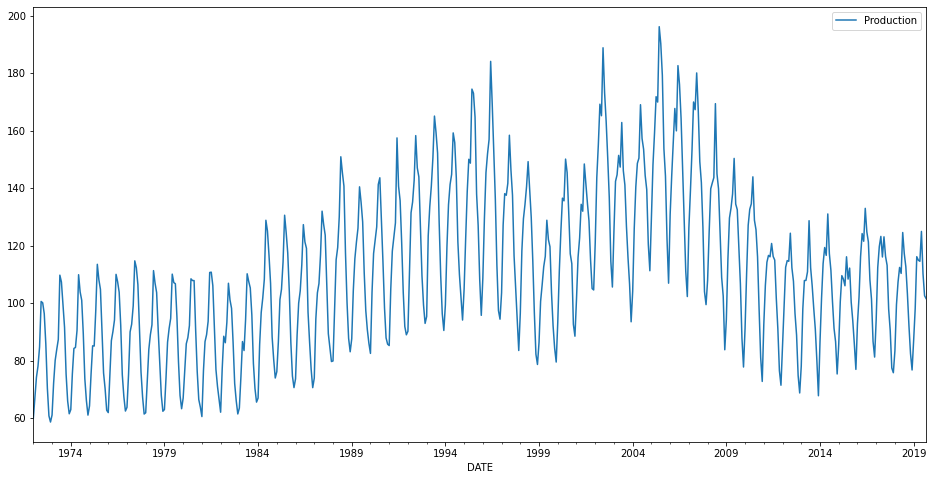

In [11]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
test_size = 24

In [14]:
test_len = len(df)-test_size

In [15]:
test_ind = len(df)- test_size
test_ind

549

In [16]:
train = df.iloc[:test_ind]

test = df.iloc[test_ind:]

### Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [22]:
len(generator)

537

In [23]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [24]:
X, y = generator[0]

In [25]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [27]:
n_features = train_scaled.shape[1]

In [28]:
model1 = Sequential()
model1.add(LSTM(150, activation = 'tanh', input_shape = (length, n_features)))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss = 'mse')

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [32]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [33]:
len(validation_generator)

12

In [34]:
model1.fit_generator(generator,
                    epochs = 35,
                    validation_data = validation_generator,
                   callbacks = [early_stop])

Epoch 1/35
537/537 [==============================] - 5s 6ms/step - loss: 0.0231 - val_loss: 0.0018
Epoch 2/35
537/537 [==============================] - 3s 5ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 3/35
537/537 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 4/35
537/537 [==============================] - 3s 6ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 5/35
537/537 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 6/35
537/537 [==============================] - 3s 5ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 7/35
537/537 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 8/35
537/537 [==============================] - 3s 5ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 9/35
537/537 [==============================] - 3s 6ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 10/35
537/537 [==============================] - 3s 5ms/step - loss: 0.0034 - val_loss: 0.0019

<AxesSubplot:>

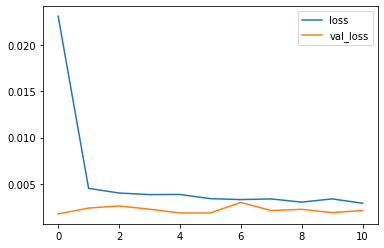

In [35]:
loss_df = pd.DataFrame(model1.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model1.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [39]:
true_predictions = scaler.inverse_transform(test_predictions)|

In [40]:
test['Predictions'] = true_predictions

In [42]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,88.210224
2017-11-01,77.4378,84.007207
2017-12-01,75.8118,88.054860
2018-01-01,83.4343,97.516337
2018-02-01,99.4899,107.255855
2018-03-01,107.3152,115.187928
2018-04-01,112.4309,121.389339
2018-05-01,110.3544,124.864473
2018-06-01,124.5841,124.199395


<AxesSubplot:xlabel='DATE'>

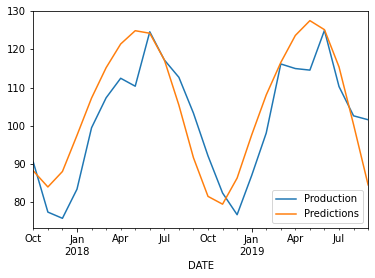

In [43]:
test.plot()

### Calculation R2 Score and Error Metrics


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [46]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [47]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: 0.6259251948280935 
mae: 7.6613266351642695 
mse: 82.78921277293561 
rmse: 9.098857772980937


### with "relu" activation function

In [48]:
model2 = Sequential()
model2.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [49]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               91200     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [50]:
model2.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 6s 8ms/step - loss: 0.0212 - val_loss: 0.0084
Epoch 2/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 3/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 4/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 5/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 6/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 7/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/20
537/537 [==============================] - 3s 6ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/20
537/537 [==============================] - 3s 5ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 10/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0031 - val_loss: 0.0020

<AxesSubplot:>

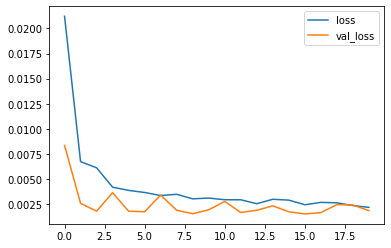

In [51]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [55]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model2.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [56]:
true_predictions = scaler.inverse_transform(test_predictions)

In [57]:
test['Predictions'] = true_predictions

In [58]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,92.845008
2017-11-01,77.4378,86.456942
2017-12-01,75.8118,87.351044
2018-01-01,83.4343,98.700964
2018-02-01,99.4899,110.857378
2018-03-01,107.3152,119.278683
2018-04-01,112.4309,126.026728
2018-05-01,110.3544,130.131805
2018-06-01,124.5841,131.568810


<AxesSubplot:xlabel='DATE'>

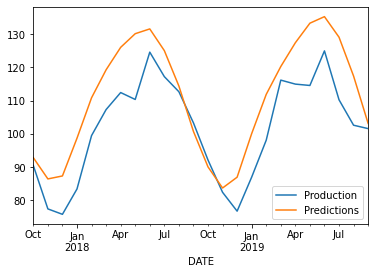

In [59]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [60]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [61]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: 0.41721728265189506 
mae: 9.796879745389887 
mse: 128.97987707231277 
rmse: 11.35693079455505


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [62]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [63]:
length = 24 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [64]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=8)

Epoch 1/8
549/549 [==============================] - 8s 12ms/step - loss: 0.0257
Epoch 2/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0080
Epoch 3/8
549/549 [==============================] - 6s 12ms/step - loss: 0.0044
Epoch 4/8
549/549 [==============================] - 7s 12ms/step - loss: 0.0035
Epoch 5/8
549/549 [==============================] - 6s 12ms/step - loss: 0.0032
Epoch 6/8
549/549 [==============================] - 7s 12ms/step - loss: 0.0035
Epoch 7/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0031
Epoch 8/8
549/549 [==============================] - 7s 13ms/step - loss: 0.0033


In [65]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [66]:
forecast = scaler.inverse_transform(forecast)

In [67]:
forecast

array([[ 85.97440592],
       [ 78.10835884],
       [ 76.46898344],
       [ 81.99064829],
       [ 92.39820058],
       [102.39756266],
       [109.73550726],
       [114.75835152],
       [116.87585963],
       [113.35050993],
       [104.18730225],
       [ 91.17488196],
       [ 78.19731715],
       [ 68.85142763],
       [ 67.06231354],
       [ 73.53335008],
       [ 85.29924857],
       [ 95.99905205],
       [103.60433262],
       [109.25264929],
       [112.52896573],
       [111.13915636],
       [104.18675309],
       [ 92.59891157]])

In [68]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [69]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [70]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [71]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [72]:
forecast_df

,Forecast
2019-10-01,85.974406
2019-11-01,78.108359
2019-12-01,76.468983
2020-01-01,81.990648
2020-02-01,92.398201
2020-03-01,102.397563
2020-04-01,109.735507
2020-05-01,114.758352
2020-06-01,116.875860
2020-07-01,113.350510


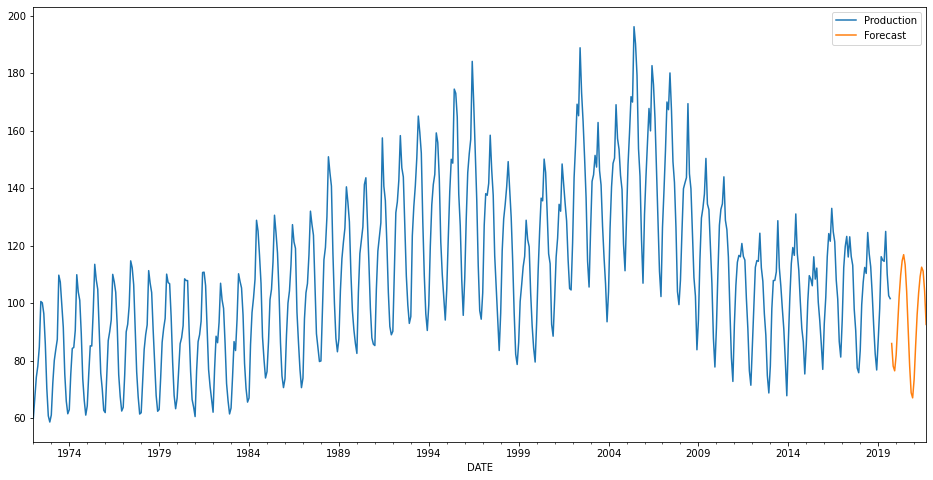

In [73]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

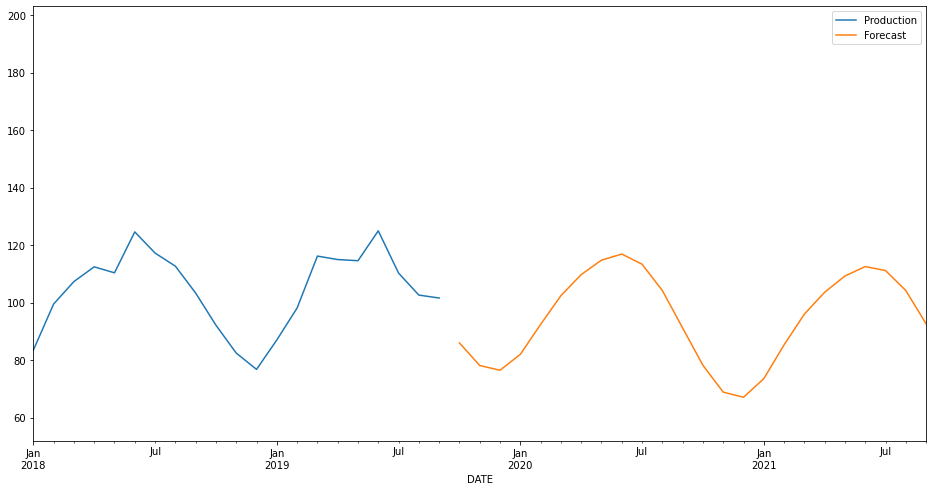

In [74]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')